In [ ]:
import pandas as pd

# 방법 1: raw string (추천)
df = pd.read_csv(r"dataset/my_dataset/df_new_2.csv")

In [6]:
print(df.head())

              date  cvprecipr      dswrf  fvmax_50m  fvmin_50m       hcc  \
0  2020-01-02 0:00   0.003905  111.88281   8.548861   8.431797  0.152649   
1  2020-01-02 1:00   0.011452  258.71042   9.016828   8.387072  0.000000   
2  2020-01-02 2:00   0.021348  385.61250   9.082644   8.784274  0.000000   
3  2020-01-02 3:00   0.031884  468.65910   8.749963   7.899988  0.000000   
4  2020-01-02 4:00   0.043603  492.25450   8.347463   7.631493  0.000000   

        lcc       lhnf  lsprecip  lsprecipr  ...  wind_dir_sin  wind_dir_cos  \
0  0.000000   3.463112       0.0        0.0  ...     -0.879530      0.475844   
1  0.000000   7.625702       0.0        0.0  ...     -0.897914      0.440171   
2  0.000000  14.090698       0.0        0.0  ...     -0.890101      0.455764   
3  0.090363  21.724625       0.0        0.0  ...     -0.894413      0.447241   
4  0.078217  29.783371       0.0        0.0  ...     -0.922975      0.384859   

   air_density  wind_speed_dir_interaction  hour  month  sin_h

In [30]:
df.columns

Index(['date', 'cvprecipr', 'dswrf', 'fvmax_50m', 'fvmin_50m', 'hcc', 'lcc',
       'lhnf', 'lsprecip', 'lsprecipr', 'lssnow', 'lssnowr', 'maxsa_1p5m',
       'mcc', 'mgws_0m', 'p', 'pblh', 'pmsl', 'rh_1p5m', 'sfa_1p5m', 'sh_1p5m',
       'snowmelt', 'ta', 'ta_1p5m', 'tdp_1p5m', 'usm_5m', 'uws_10m', 'vsm_5m',
       'vws_10m', 'energy_kwh', 'wind_speed_10m', 'wind_speed_5m',
       'wind_speed_eff_10m', 'wind_speed_sq', 'wind_speed_cu',
       'turbulence_intensity', 'wind_dir_10m', 'wind_dir_sin', 'wind_dir_cos',
       'air_density', 'wind_speed_dir_interaction', 'hour', 'month',
       'sin_hour', 'cos_hour', 'sin_month', 'cos_month'],
      dtype='object')

In [43]:
# ==============================================================================
# iTransformer 최종 실행 코드 (모든 정의 및 데이터 처리 포함) ㅇㅇ
# ==============================================================================

# --- 1. 기본 라이브러리 및 모델 불러오기 ---
import torch
import torch.optim as optim
import torch.nn as nn
import time
import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# --- 외부 파일 의존성 제거: 필요한 클래스와 함수를 직접 정의 ---
class Dataset_Custom(Dataset):
    def __init__(self, data_x, data_y, data_stamp, size=None):
        self.data_x, self.data_y, self.data_stamp = data_x, data_y, data_stamp
        if size is None:
            self.seq_len, self.label_len, self.pred_len = 384, 96, 96
        else:
            self.seq_len, self.label_len, self.pred_len = size[0], size[1], size[2]

    def __getitem__(self, index):
        s_begin, s_end = index, index + self.seq_len
        r_begin, r_end = s_end - self.label_len, s_end - self.label_len + self.label_len + self.pred_len
        return self.data_x[s_begin:s_end], self.data_y[r_begin:r_end], self.data_stamp[s_begin:s_end], self.data_stamp[r_begin:r_end]

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

def data_provider(args, flag, data_x, data_y, data_stamp):
    shuffle_flag = flag in ['train', 'val']
    drop_last = flag in ['train', 'val']
    batch_size = args.batch_size if flag in ['train', 'val'] else 1
    data_set = Dataset_Custom(data_x, data_y, data_stamp, [args.seq_len, args.label_len, args.pred_len])
    print(f"'{flag}' data loaded with {len(data_set)} samples.")
    return data_set, DataLoader(data_set, batch_size=batch_size, shuffle=shuffle_flag, num_workers=args.num_workers, drop_last=drop_last)

# --- 2. 모델 설정 (제어판) ---
class Config:
    root_path, data_path = 'C:/Users/User/OneDrive/바탕 화면/iTransformer/dataset/my_dataset', 'df_new_2.csv'
    enc_in = 46              # 입력 변수 수 (target 포함)
    target = 'energy_kwh'
    data = 'custom'
    features = 'S'
    freq = 'h'

    # --- 시퀀스 길이 및 예측 길이 ---
    seq_len = 168            # 입력 길이: 2주치
    label_len = 168          # decoder 초기 입력 길이: 1주치
    pred_len = 1            # 예측 길이: 1시간

    # --- 모델 구조 ---
    factor = 3
    output_attention = False
    use_norm = True
    class_strategy = 'projection'

    d_model = 256            # 모델 차원 ↑
    n_heads = 8              # 멀티헤드 수
    e_layers = 1             # encoder 레이어 수 ↑
    d_layers = 1             # decoder 레이어 수 ↑
    d_ff = 2048              # feed-forward 차원

    dropout = 0.2            # 드롭아웃 0.2~0.3 권장
    activation = 'gelu'
    dec_in = enc_in
    c_out = enc_in

    # --- 학습 ---
    batch_size = 64          # GPU 허용 범위에서 증가
    num_workers = 0
    model = 'iTransformer'
    embed = 'timeF'
    train_epochs = 3        # epoch ↑
    learning_rate = 0.0001   # LR 스케줄러 적용 가능
    
args = Config()


In [44]:
# --- 3. 데이터 처리 및 스케일링 (노트북에서 직접 수행) ---
print(">>>>>>> 데이터 처리를 시작합니다 >>>>>>>")
sys.path.append('.') 
from model import iTransformer

df_raw = pd.read_csv(os.path.join(args.root_path, args.data_path))
df_raw['date'] = pd.to_datetime(df_raw['date'])

df_train = df_raw[df_raw['date'].dt.year <= 2021].copy()
df_val = df_raw[df_raw['date'].dt.year == 2022].copy()
df_test = df_raw[df_raw['date'].dt.year == 2023].copy()

df_cols = [col for col in df_train.columns if col not in ['date', args.target]]
data_cols_ordered = df_cols + [args.target]

df_train_data = df_train[data_cols_ordered]
scaler = StandardScaler().fit(df_train_data.values)

train_scaled = scaler.transform(df_train[data_cols_ordered].values).astype(np.float32)
val_scaled = scaler.transform(df_val[data_cols_ordered].values).astype(np.float32)
test_scaled = scaler.transform(df_test[data_cols_ordered].values).astype(np.float32)

def create_stamp(df):
    return pd.DataFrame({
        'month': df['date'].dt.month, 'day': df['date'].dt.day,
        'weekday': df['date'].dt.weekday, 'hour': df['date'].dt.hour
    }).values.astype(np.float32)

train_stamp, val_stamp, test_stamp = create_stamp(df_train), create_stamp(df_val), create_stamp(df_test)

# --- 4. 데이터 로더 및 모델 생성 ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_data, train_loader = data_provider(args, 'train', train_scaled, train_scaled, train_stamp)
val_data, val_loader = data_provider(args, 'val', val_scaled, val_scaled, val_stamp)
test_data, test_loader = data_provider(args, 'test', test_scaled, test_scaled, test_stamp)

print("\n모델 생성 중...")
model = iTransformer.Model(args).to(device)
print(f"\n🎉 모델과 데이터 로딩 준비가 완료되었습니다! (사용 장치: {device})")

# --- (이하 학습 및 평가 코드는 이전과 동일하게 이어서 실행) ---

>>>>>>> 데이터 처리를 시작합니다 >>>>>>>
'train' data loaded with 15792 samples.
'val' data loaded with 8424 samples.
'test' data loaded with 8592 samples.

모델 생성 중...

🎉 모델과 데이터 로딩 준비가 완료되었습니다! (사용 장치: cpu)


# 모델 학습(train)

In [45]:
# EarlyStopping, 진행상황 추가버전

import numpy as np
import time
import sys

# --- EarlyStopping 클래스 ---
class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# --- 학습 시작 ---
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.SmoothL1Loss()

early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

print(">>>>>>> 학습을 시작합니다 >>>>>>>")
start_time = time.time()

total_steps = args.train_epochs * len(train_loader)
completed_steps = 0

for epoch in range(args.train_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start = time.time()

    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        step_start = time.time()
        optimizer.zero_grad()
        
        # --- 데이터 GPU/CPU 이동 ---
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x_mark, batch_y_mark = batch_x_mark.to(device), batch_y_mark.to(device)

        # --- Decoder 입력 구성 (Teacher Forcing 제거) ---
        decoder_input_start = batch_x[:, -args.label_len:, :] 
        decoder_input_placeholder = torch.zeros_like(batch_y[:, -args.pred_len:, :])
        dec_inp = torch.cat([decoder_input_start, decoder_input_placeholder], dim=1).to(device)

        # --- Forward & Loss 계산 ---
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :]

        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()

        # --- Backpropagation ---
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # --- 진행 상황 및 ETA ---
        completed_steps += 1
        step_time = time.time() - step_start
        avg_step_time = (time.time() - start_time) / completed_steps
        remaining_steps = total_steps - completed_steps
        eta = remaining_steps * avg_step_time

        progress = (completed_steps / total_steps) * 100
        sys.stdout.write(
            f"\r[Epoch {epoch+1}/{args.train_epochs}] "
            f"Step {i+1}/{len(train_loader)} "
            f"Progress: {progress:.2f}% "
            f"| Loss: {loss.item():.6f} "
            f"| ETA: {eta/60:.1f} min"
        )
        sys.stdout.flush()

    # --- Train Epoch 결과 ---
    avg_train_loss = epoch_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    # --- Validation Loss 계산 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_x_mark, batch_y_mark = batch_x_mark.to(device), batch_y_mark.to(device)

            decoder_input_start = batch_x[:, -args.label_len:, :]
            decoder_input_placeholder = torch.zeros_like(batch_y[:, -args.pred_len:, :])
            dec_inp = torch.cat([decoder_input_start, decoder_input_placeholder], dim=1).to(device)

            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            outputs = outputs[:, -args.pred_len:, :]
            batch_y = batch_y[:, -args.pred_len:, :]

            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"\nEpoch {epoch+1}/{args.train_epochs} "
          f"| Train Loss: {avg_train_loss:.6f} "
          f"| Val Loss: {avg_val_loss:.6f} "
          f"| Epoch Time: {epoch_time:.1f}s")

    # --- EarlyStopping ---
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\n>>>>>>> 학습 완료! 총 소요 시간: {total_time/60:.2f}분 >>>>>>>")


>>>>>>> 학습을 시작합니다 >>>>>>>
[Epoch 1/3] Step 246/246 Progress: 33.33% | Loss: 0.043680 | ETA: 1.9 min
Epoch 1/3 | Train Loss: 0.076307 | Val Loss: 0.044743 | Epoch Time: 55.8s
[Epoch 2/3] Step 246/246 Progress: 66.67% | Loss: 0.062894 | ETA: 1.0 min
Epoch 2/3 | Train Loss: 0.052859 | Val Loss: 0.041082 | Epoch Time: 55.7s
[Epoch 3/3] Step 246/246 Progress: 100.00% | Loss: 0.046128 | ETA: 0.0 min
Epoch 3/3 | Train Loss: 0.048278 | Val Loss: 0.038483 | Epoch Time: 55.7s

>>>>>>> 학습 완료! 총 소요 시간: 3.26분 >>>>>>>


# 성능 확인(train->val)

>>>>>>> 전체 검증 데이터셋 성능 평가 시작 >>>>>>>

Validation NMAE (2022년 전체, mask 기반, %): 8.5287

--- 2022년 전체 Validation 상위 20개 샘플 비교 ---
                  date        Actual     Predicted   Difference
0  2022-01-01 00:00:00  18421.875000  19455.212891 -1033.337891
1  2022-01-01 01:00:00   3113.281006   2725.483643   387.797363
2  2022-01-01 02:00:00      0.000340     78.817238   -78.816895
3  2022-01-01 03:00:00    972.656128    459.364594   513.291504
4  2022-01-01 04:00:00   9724.609375   9450.772461   273.836914
5  2022-01-01 05:00:00   9339.843750   9693.836914  -353.993164
6  2022-01-01 06:00:00   4607.421875   3614.645264   992.776611
7  2022-01-01 07:00:00   1605.469116   1378.888550   226.580566
8  2022-01-01 08:00:00   2619.140625   7364.560547 -4745.419922
9  2022-01-01 09:00:00  17771.484375  17516.347656   255.136719
10 2022-01-01 10:00:00   8869.140625   6647.831055  2221.309570
11 2022-01-01 11:00:00  17779.296875  18185.263672  -405.966797
12 2022-01-01 12:00:00   1986.328003   386

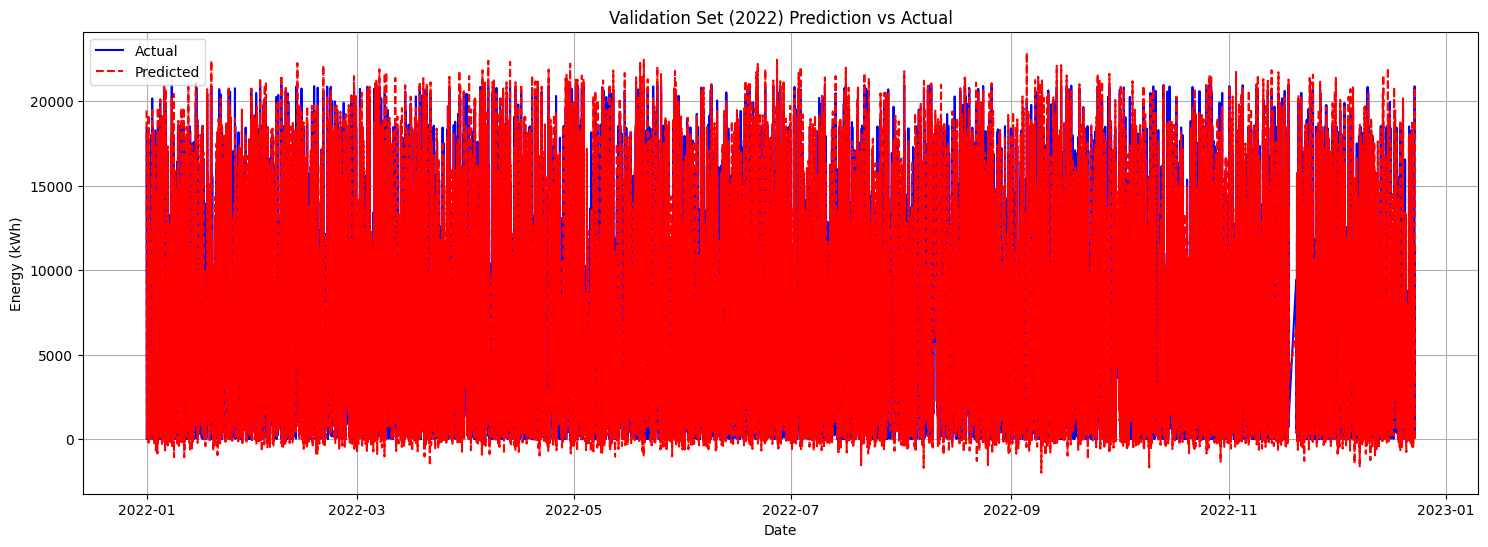

In [65]:
# ==============================================================================
# 2022년 전체 Validation 시계열 예측 및 성능 평가 (mask NMAE 포함)
# ==============================================================================
print(">>>>>>> 전체 검증 데이터셋 성능 평가 시작 >>>>>>>")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. NMAE 계산 함수 ---
def compute_nmae_masked(y_true, y_pred, capacity):
    """
    이전 방식 NMAE 계산 (y_true >= 0.1 * capacity에 대해서만 계산, 샘플 수 부족 시 전체 사용)
    """
    y_true_flat = y_true.flatten()
    mask = y_true_flat >= 0.1 * capacity
    if mask.sum() < 10:  # 충분한 샘플이 없으면 전체 사용
        mask = slice(None)
    nmae_score = np.mean(np.abs(y_true_flat[mask] - y_pred.flatten()[mask])) / capacity * 100
    return nmae_score

# --- 2. 전체 예측값과 실제값 수집 ---
preds, trues = [], []
model.eval()
with torch.no_grad():
    for batch_x, batch_y, batch_x_mark, batch_y_mark in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x_mark = batch_x_mark.to(device)
        batch_y_mark = batch_y_mark.to(device)

        # Decoder 입력 생성 (Teacher Forcing 제거)
        decoder_input_start = batch_x[:, -args.label_len:, :]
        decoder_input_placeholder = torch.zeros_like(batch_y[:, -args.pred_len:, :])
        dec_inp = torch.cat([decoder_input_start, decoder_input_placeholder], dim=1)

        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        outputs = outputs[:, -args.pred_len:, :]

        batch_y = batch_y[:, -args.pred_len:, :]

        preds.append(outputs.cpu())
        trues.append(batch_y.cpu())

# --- 3. 전체 예측/실제값 결합 및 역변환 ---
preds = torch.cat(preds, dim=0).numpy().reshape(-1, args.enc_in)
trues = torch.cat(trues, dim=0).numpy().reshape(-1, args.enc_in)

inverse_preds_all = scaler.inverse_transform(preds)
inverse_trues_all = scaler.inverse_transform(trues)

# target 변수만 추출
target_idx = data_cols_ordered.index(args.target)
inverse_preds_target = inverse_preds_all[:, target_idx]
inverse_trues_target = inverse_trues_all[:, target_idx]

# --- 4. 날짜 매칭 ---
val_dates = pd.to_datetime(df_val['date'].reset_index(drop=True))[:len(inverse_trues_target)]

# --- 5. 결과 데이터프레임 생성 ---
results_df = pd.DataFrame({
    'date': val_dates,
    'Actual': inverse_trues_target,
    'Predicted': inverse_preds_target
})
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# --- 6. Capacity 계산 ---
capacity = inverse_trues_target.max()

# --- 7. NMAE 계산 ---
nmae_masked = compute_nmae_masked(results_df['Actual'].values, results_df['Predicted'].values, capacity)
print(f"\nValidation NMAE (2022년 전체, mask 기반, %): {nmae_masked:.4f}")

# --- 8. 상위 20개 샘플 출력 ---
print("\n--- 2022년 전체 Validation 상위 20개 샘플 비교 ---")
print(results_df.head(20))

# --- 9. 시각화 ---
plt.figure(figsize=(18, 6))
plt.plot(results_df['date'], results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df['date'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('Validation Set (2022) Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()


# 모델 학습(train+val)

In [66]:
# ================================
# 1️⃣ train+val 합치기
# ================================
full_train_scaled = np.concatenate([train_scaled, val_scaled], axis=0)
full_train_stamp = np.concatenate([train_stamp, val_stamp], axis=0)

full_train_data = Dataset_Custom(full_train_scaled, full_train_scaled, full_train_stamp,
                                 size=[args.seq_len, args.label_len, args.pred_len])
full_train_loader = DataLoader(full_train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

print(f"Train+Val 데이터셋 로드 완료: {len(full_train_data)} 샘플")


Train+Val 데이터셋 로드 완료: 24384 샘플


In [67]:
# ================================
# 1️⃣ 모델 재생성 / optimizer 설정
# ================================
model = iTransformer.Model(args).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.SmoothL1Loss()

# ================================
# 2️⃣ EarlyStopping 클래스
# ================================
class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

# ================================
# 3️⃣ train+val 학습 루프 (진행상황 표시 포함)
# ================================
print(">>>>>>> train+val 학습을 시작합니다 >>>>>>>")
start_time = time.time()

total_steps = args.train_epochs * len(full_train_loader)
completed_steps = 0

for epoch in range(args.train_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start = time.time()

    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(full_train_loader):
        step_start = time.time()
        optimizer.zero_grad()

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x_mark = batch_x_mark.to(device)
        batch_y_mark = batch_y_mark.to(device)

        # --- Decoder 입력 구성 (Teacher Forcing 제거) ---
        decoder_input_start = batch_x[:, -args.label_len:, :]
        decoder_input_placeholder = torch.zeros_like(batch_y[:, -args.pred_len:, :])
        dec_inp = torch.cat([decoder_input_start, decoder_input_placeholder], dim=1).to(device)

        # --- Forward & Loss ---
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :]

        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()

        # --- Backpropagation ---
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # --- 진행상황 및 ETA 계산 ---
        completed_steps += 1
        step_time = time.time() - step_start
        avg_step_time = (time.time() - start_time) / completed_steps
        remaining_steps = total_steps - completed_steps
        eta = remaining_steps * avg_step_time

        progress = (completed_steps / total_steps) * 100
        sys.stdout.write(
            f"\r[Epoch {epoch+1}/{args.train_epochs}] "
            f"Step {i+1}/{len(full_train_loader)} "
            f"Progress: {progress:.2f}% "
            f"| Loss: {loss.item():.6f} "
            f"| ETA: {eta/60:.1f} min"
        )
        sys.stdout.flush()

    avg_epoch_loss = epoch_loss / len(full_train_loader)
    epoch_time = time.time() - epoch_start

    print(f"\nEpoch {epoch+1}/{args.train_epochs} "
          f"| Avg Loss: {avg_epoch_loss:.6f} "
          f"| Epoch Time: {epoch_time:.1f}s")

    # --- EarlyStopping 적용 ---
    early_stopping(avg_epoch_loss)
    if early_stopping.early_stop:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\n>>>>>>> train+val 학습 완료! 총 소요 시간: {total_time/60:.2f}분 >>>>>>>")


>>>>>>> train+val 학습을 시작합니다 >>>>>>>
[Epoch 1/3] Step 381/381 Progress: 33.33% | Loss: 0.041536 | ETA: 2.9 min
Epoch 1/3 | Avg Loss: 0.071164 | Epoch Time: 88.4s
[Epoch 2/3] Step 381/381 Progress: 66.67% | Loss: 0.046337 | ETA: 1.5 min
Epoch 2/3 | Avg Loss: 0.048640 | Epoch Time: 87.0s
[Epoch 3/3] Step 381/381 Progress: 100.00% | Loss: 0.043862 | ETA: 0.0 min
Epoch 3/3 | Avg Loss: 0.044471 | Epoch Time: 86.5s

>>>>>>> train+val 학습 완료! 총 소요 시간: 4.37분 >>>>>>>


# 성능확인(train+val -> test)

>>>>>>> 전체 Test 데이터셋 성능 평가 시작 >>>>>>>

Test NMAE (mask 기반, %): 8.4146

--- Test 데이터 상위 20개 샘플 비교 ---
                  date        Actual     Predicted   Difference
0  2023-01-01 00:00:00  14884.765625  16076.475586 -1191.709961
1  2023-01-01 01:00:00  15162.109375  15935.106445  -772.997070
2  2023-01-01 02:00:00  12652.343750  16254.430664 -3602.086914
3  2023-01-01 03:00:00  11634.765625  14319.916016 -2685.150391
4  2023-01-01 04:00:00  13490.234375  13107.210938   383.023438
5  2023-01-01 05:00:00  15296.875000  14108.165039  1188.709961
6  2023-01-01 06:00:00  14898.437500  15452.232422  -553.794922
7  2023-01-01 07:00:00  15482.421875  15163.319336   319.102539
8  2023-01-01 08:00:00  17597.656250  15378.138672  2219.517578
9  2023-01-01 09:00:00  17451.171875  17213.539062   237.632812
10 2023-01-01 10:00:00  17503.906250  17389.679688   114.226562
11 2023-01-01 11:00:00  16328.125000  16986.388672  -658.263672
12 2023-01-01 12:00:00  12966.796875  15684.542969 -2717.746094
13 

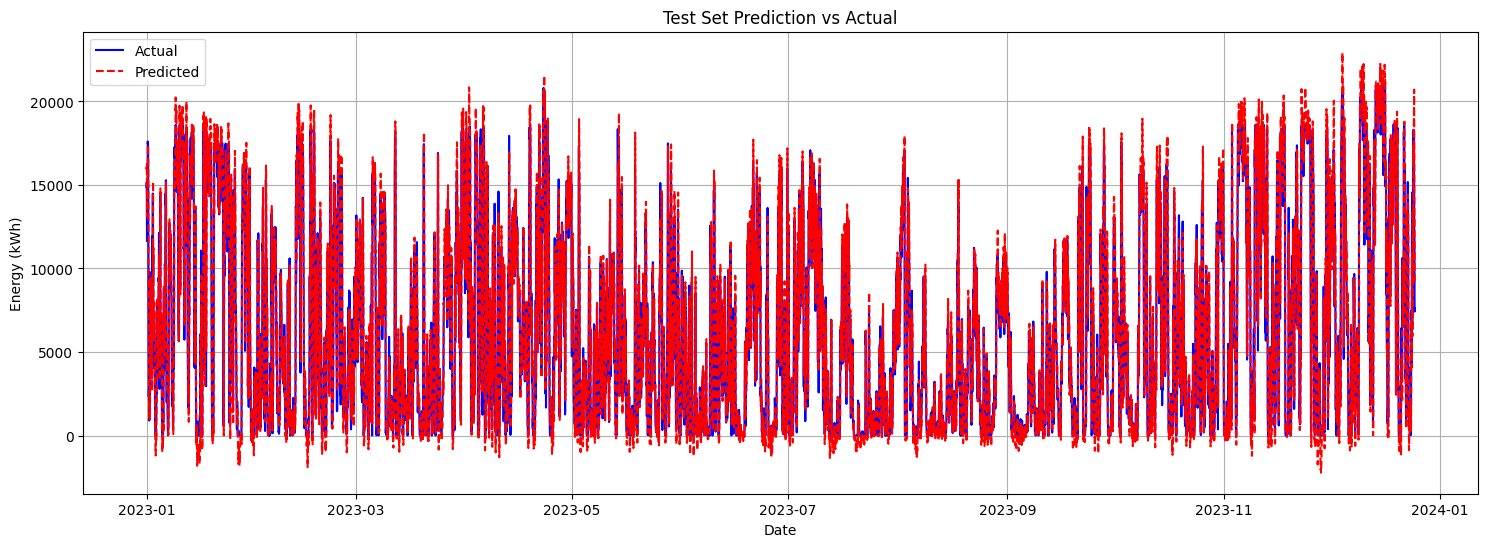

In [68]:
# ==============================================================================
#                 전체 테스트 데이터셋 성능 평가 (val 형식 적용)
# ==============================================================================
print(">>>>>>> 전체 Test 데이터셋 성능 평가 시작 >>>>>>>")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. NMAE 계산 함수 (mask 기반) ---
def compute_nmae_masked(y_true, y_pred, capacity):
    y_true_flat = y_true.flatten()
    mask = y_true_flat >= 0.1 * capacity
    if mask.sum() < 10:
        mask = slice(None)
    nmae_score = np.mean(np.abs(y_true_flat[mask] - y_pred.flatten()[mask])) / capacity * 100
    return nmae_score

# --- 2. 전체 예측값과 실제값 수집 ---
preds, trues = [], []
model.eval()
with torch.no_grad():
    for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x_mark = batch_x_mark.to(device)
        batch_y_mark = batch_y_mark.to(device)

        # Decoder 입력 생성 (Teacher Forcing 제거)
        decoder_input_start = batch_x[:, -args.label_len:, :]
        decoder_input_placeholder = torch.zeros_like(batch_y[:, -args.pred_len:, :])
        dec_inp = torch.cat([decoder_input_start, decoder_input_placeholder], dim=1)

        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :]

        preds.append(outputs.cpu())
        trues.append(batch_y.cpu())

# --- 3. 전체 예측/실제값 결합 및 역변환 ---
preds = torch.cat(preds, dim=0).numpy().reshape(-1, args.enc_in)
trues = torch.cat(trues, dim=0).numpy().reshape(-1, args.enc_in)

inverse_preds_all = scaler.inverse_transform(preds)
inverse_trues_all = scaler.inverse_transform(trues)

# target 변수만 추출
target_idx = data_cols_ordered.index(args.target)
inverse_preds_target = inverse_preds_all[:, target_idx]
inverse_trues_target = inverse_trues_all[:, target_idx]

# --- 4. 날짜 매칭 (전체 test 길이에 맞춤) ---
test_dates = pd.to_datetime(df_test['date'].reset_index(drop=True))[:len(inverse_trues_target)]

# --- 5. 결과 데이터프레임 생성 ---
results_df = pd.DataFrame({
    'date': test_dates,
    'Actual': inverse_trues_target,
    'Predicted': inverse_preds_target
})
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# --- 6. Capacity 계산 ---
capacity = inverse_trues_target.max()

# --- 7. NMAE 계산 (mask 기반) ---
nmae_masked = compute_nmae_masked(results_df['Actual'].values, results_df['Predicted'].values, capacity)
print(f"\nTest NMAE (mask 기반, %): {nmae_masked:.4f}")

# --- 8. 상위 20개 샘플 출력 ---
print("\n--- Test 데이터 상위 20개 샘플 비교 ---")
print(results_df.head(20))

# --- 9. 시각화 ---
plt.figure(figsize=(18, 6))
plt.plot(results_df['date'], results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df['date'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('Test Set Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()
